In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier


# Vamos analisar um conjunto de dados que um gerente de banco tem disponível sobre seus clientes. Esses dados contem certas informações sobre os clientes.

# O gerente busca um indicador da probabilidade de que seus clientes ativos cancelem o cartão (churn).

# Para isso ele pode buscar nesses dados alguma característica de semelhança entre os clientes que cancelaram e ver se isso se reflete em algum dos clientes ainda ativos. Com um indicativo da chance de um cliente cancelar sua conta, esse gerente pode tomar ações para mitigar a chance de clientes em risco cancelarem.

# Em primeiro lugar, carregamos o arquivo analisedechurn.csv :

In [2]:
df = pd.read_csv('analisedechurn.csv')  #Nome do arquivo contendo o dataset que vamos analisar

# Eliminamos as duas ultimas colunas (-1 última, -2 penúltima)
df.drop(df.columns[[-1,-2]], axis=1, inplace=True)


df.info()   # Uma rápida olhada sobre a estrutura dos dados

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [3]:
# Dentre as variáveis categóricas, vamos olhar que tipo de chaves elas possuem:
for cat in df.select_dtypes(include='object').columns:
  print(df[cat].value_counts().keys())

Index(['Existing Customer', 'Attrited Customer'], dtype='object', name='Attrition_Flag')
Index(['F', 'M'], dtype='object', name='Gender')
Index(['Graduate', 'High School', 'Unknown', 'Uneducated', 'College',
       'Post-Graduate', 'Doctorate'],
      dtype='object', name='Education_Level')
Index(['Married', 'Single', 'Unknown', 'Divorced'], dtype='object', name='Marital_Status')
Index(['Less than $40K', '$40K - $60K', '$80K - $120K', '$60K - $80K',
       'Unknown', '$120K +'],
      dtype='object', name='Income_Category')
Index(['Blue', 'Silver', 'Gold', 'Platinum'], dtype='object', name='Card_Category')


# Dentre as variáveis categóricas, vamos observar um pouco do comportamento geral delas nos blocos seguintes.

# Vamos observar o comportamento geral do dados e depois observar os valores separando entre clientes desistentes e existentes

Text(0.5, 1.0, 'Proporção da categoria de cartão')

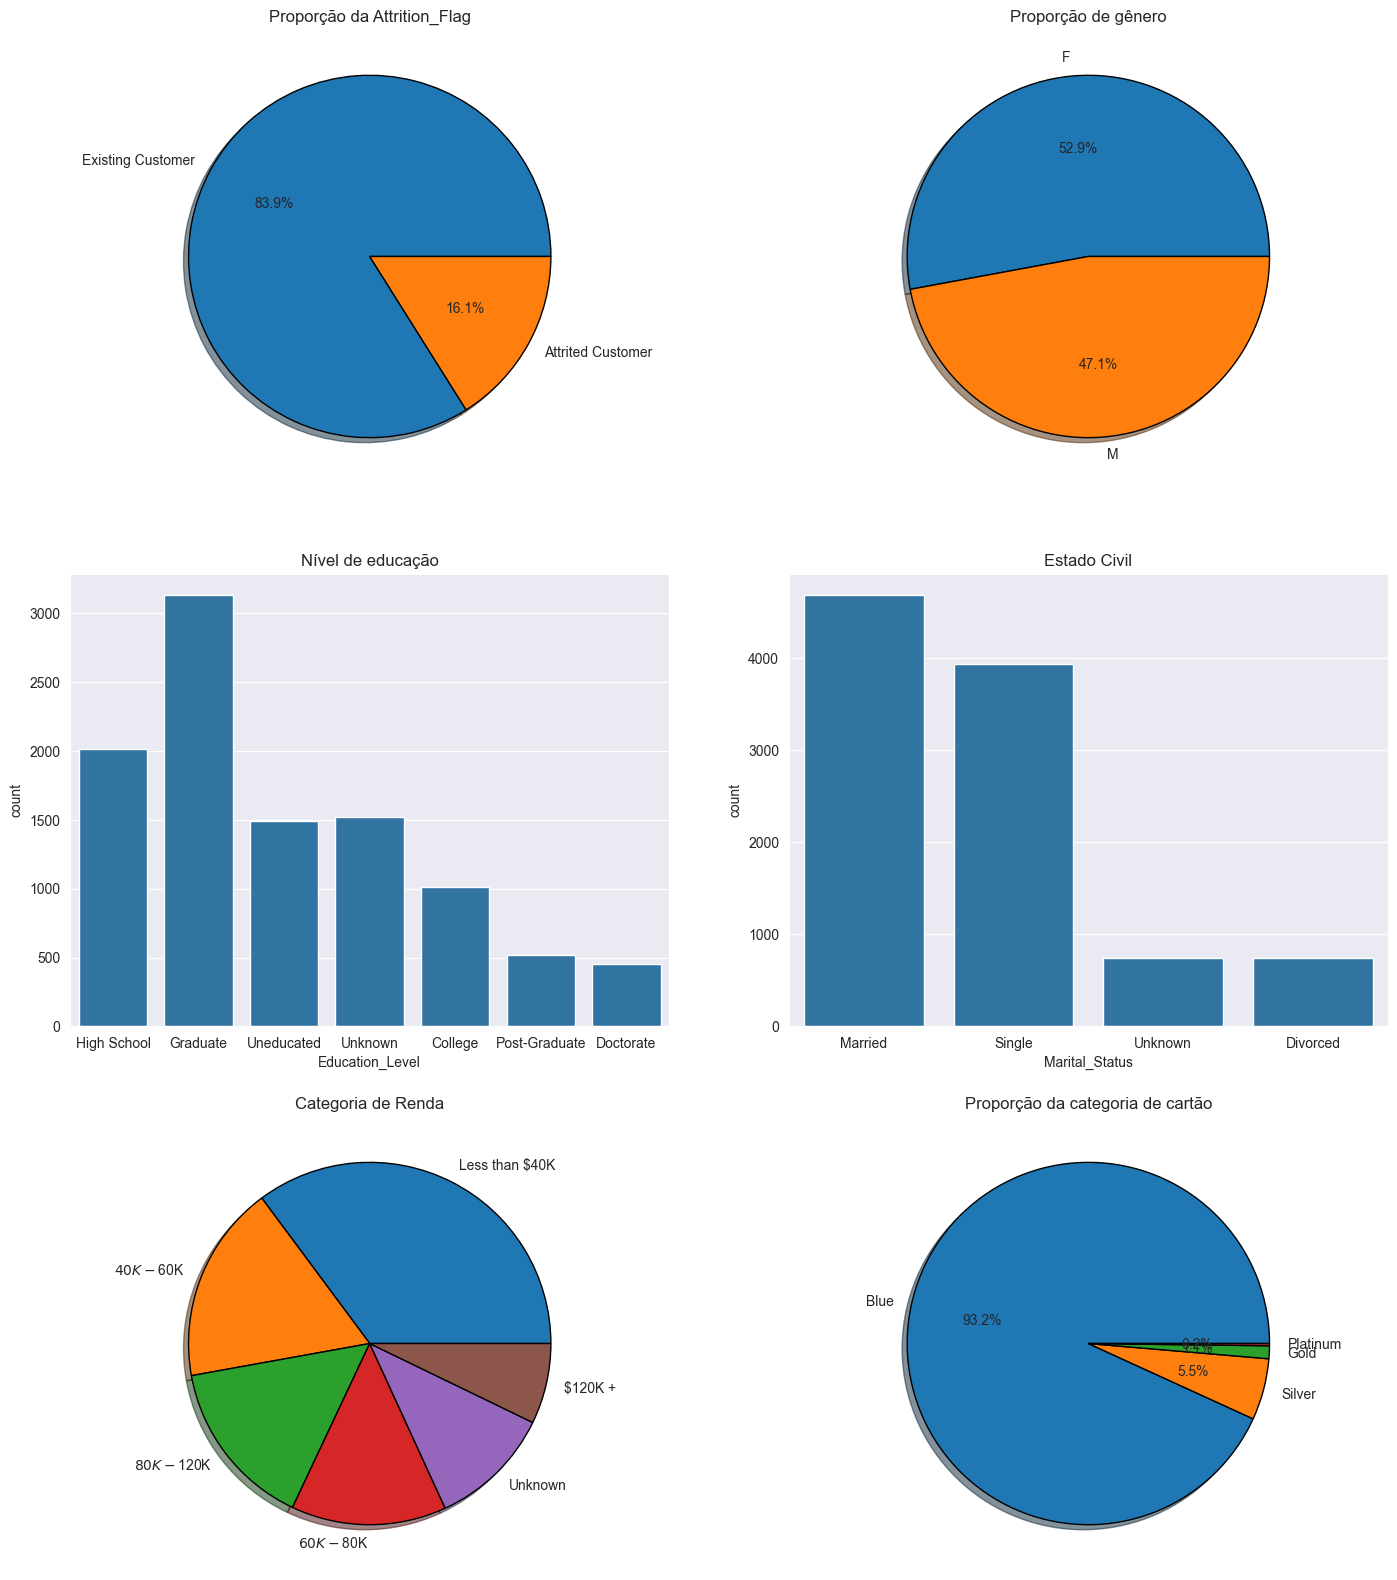

In [4]:
# Dentre as variáveis categóricas, vamos observar um pouco do comportamento geral delas

fig = plt.figure(constrained_layout=False, figsize=(17, 20))
spec = gridspec.GridSpec(ncols=2, nrows=3, figure = fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax5 = fig.add_subplot(spec[2, 0])
ax6 = fig.add_subplot(spec[2, 1])

# Attrition_Flag
labels = df['Attrition_Flag'].value_counts().keys()
ax1.pie(df['Attrition_Flag'].value_counts(),labels = labels,  autopct='%.1f%%',
        shadow=True, wedgeprops={'edgecolor': 'black'})
ax1.set_title('Proporção da Attrition_Flag')

# Gender
labels = df['Gender'].value_counts().keys()
ax2.pie(df['Gender'].value_counts(),labels = labels,  autopct='%.1f%%',
        shadow=True, wedgeprops={'edgecolor': 'black'})
ax2.set_title('Proporção de gênero')

# Education_Level
sns.countplot(ax=ax3, x=df['Education_Level'])
ax3.set_title('Nível de educação')

# Marital_Status
sns.countplot(ax=ax4, x=df['Marital_Status'])
ax4.set_title('Estado Civil')

# Income_Category
#sns.countplot(ax=ax5, x=df['Income_Category'])
labels = df['Income_Category'].value_counts().keys()
ax5.pie(df['Income_Category'].value_counts(),labels = labels,
        shadow=True, wedgeprops={'edgecolor': 'black'})
ax5.set_title('Categoria de Renda')

# Card_Category
labels = df['Card_Category'].value_counts().keys()
ax6.pie(df['Card_Category'].value_counts(),labels = labels,  autopct='%.1f%%',
        shadow=True, wedgeprops={'edgecolor': 'black'})
ax6.set_title('Proporção da categoria de cartão')

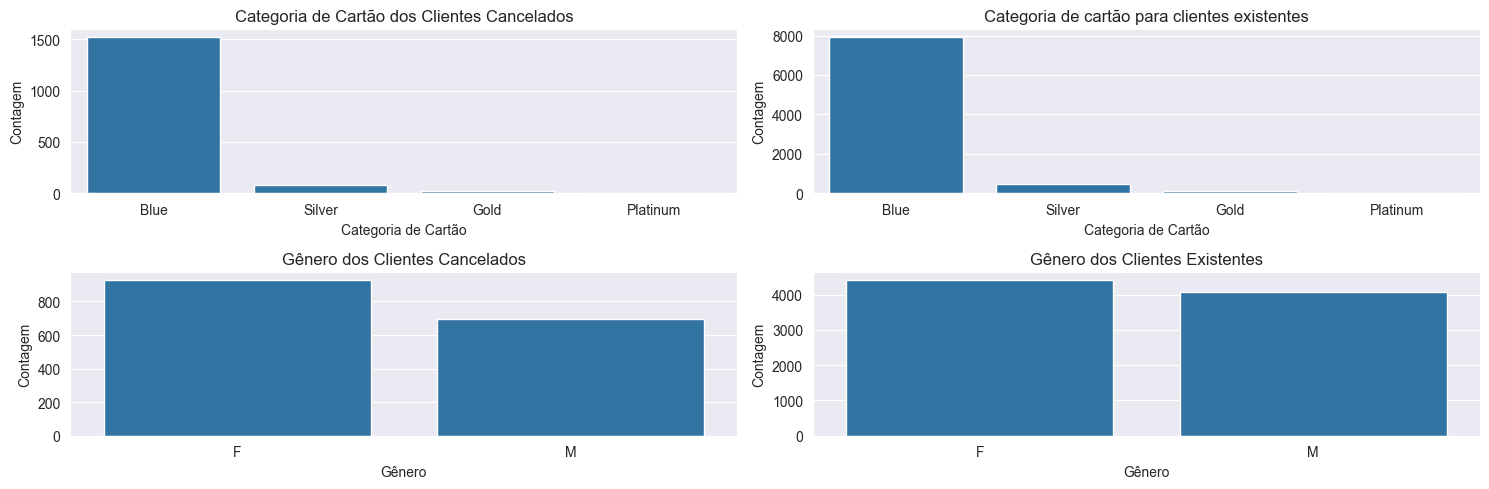

In [5]:

fig, axes = plt.subplots(2, 2, figsize=(15, 5))

# Attrited Customers
attrited_df = df[df['Attrition_Flag'] == 'Attrited Customer']
sns.countplot(x='Card_Category', data=attrited_df, ax=axes[0,0], order=['Blue',  'Silver','Gold', 'Platinum'])
axes[0,0].set_title('Categoria de Cartão dos Clientes Cancelados')
axes[0,0].set_xlabel('Categoria de Cartão')
axes[0,0].set_ylabel('Contagem')

attrited_df = df[df['Attrition_Flag'] == 'Attrited Customer']
sns.countplot(x='Gender', data=attrited_df, ax=axes[1,0])
axes[1,0].set_title('Gênero dos Clientes Cancelados')
axes[1,0].set_xlabel('Gênero')
axes[1,0].set_ylabel('Contagem')


# Existing Customers
existing_df = df[df['Attrition_Flag'] == 'Existing Customer']
sns.countplot(x='Card_Category', data=existing_df, ax=axes[0,1], order=['Blue',  'Silver','Gold', 'Platinum'])
axes[0,1].set_title('Categoria de cartão para clientes existentes')
axes[0,1].set_xlabel('Categoria de Cartão')
axes[0,1].set_ylabel('Contagem')

existing_df = df[df['Attrition_Flag'] == 'Existing Customer']
sns.countplot(x='Gender', data=existing_df, ax=axes[1,1], order = ["F", "M"])
axes[1,1].set_title('Gênero dos Clientes Existentes')
axes[1,1].set_xlabel('Gênero')
axes[1,1].set_ylabel('Contagem')


plt.tight_layout()
plt.show()


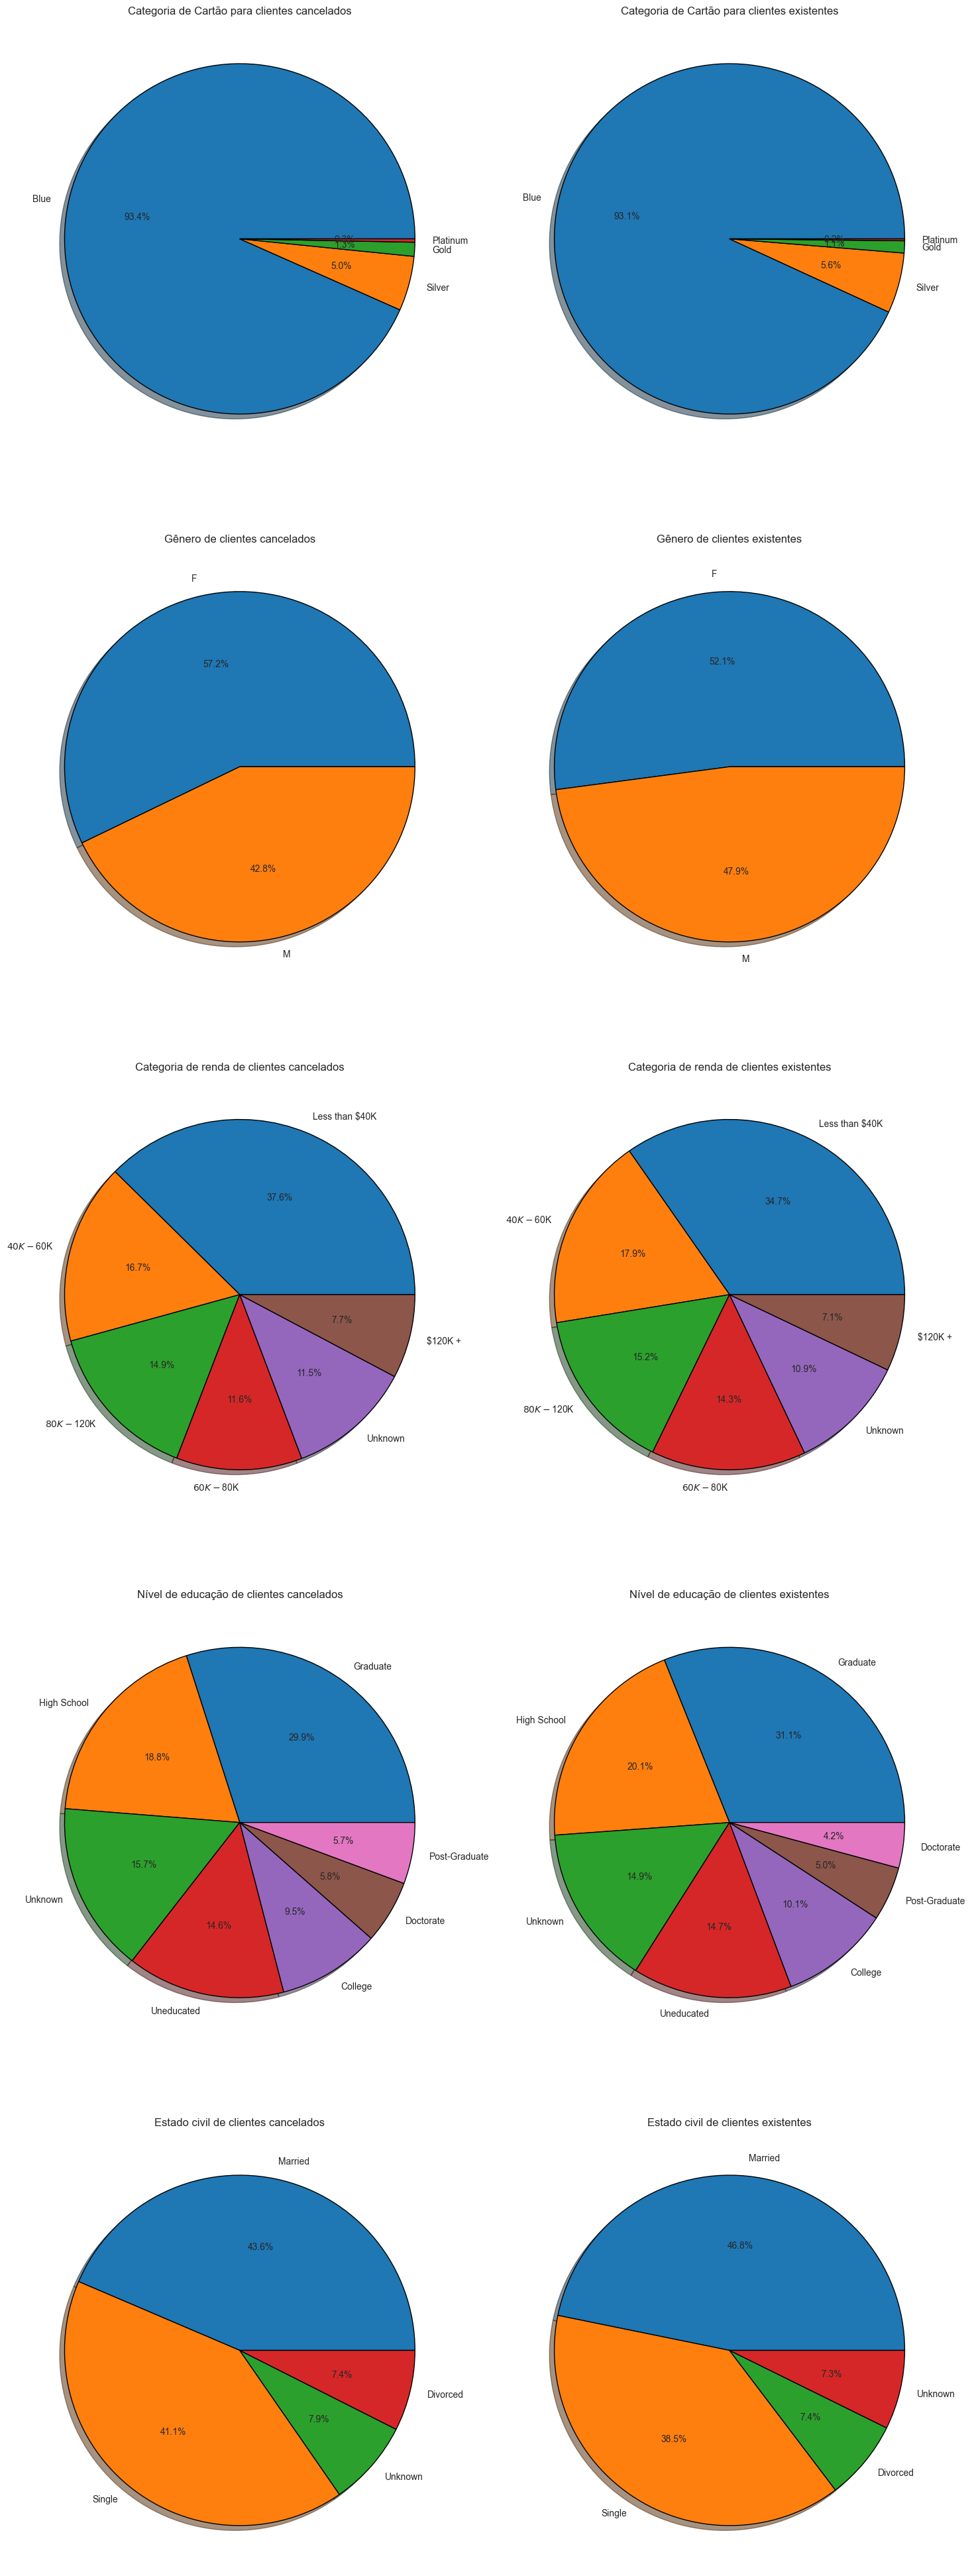

In [6]:
# Como o numero de clientes cancelados e existentes é diferente,
# talvez seja melhor visualizar esses dados na sua proporção
# usando gráfico de setores ao invés de gráficos de barra

# gera a figura e os eixos associados para os subplots. A matriz de plot possui 5 linhas por 2 colunas.
# Efeito semelhante ao uso do gridspec no bloco anterior
fig, axes = plt.subplots(5, 2, figsize=(15, 40))

##### Cliente Cancelados
attrited_df = df[df['Attrition_Flag'] == 'Attrited Customer']  # dataframe que pega apenas os clientes que cancelaram

#categoria de cartao
card_counts = attrited_df['Card_Category'].value_counts()
labels = card_counts.index
axes[0, 0].pie(card_counts, labels=labels, autopct='%.1f%%', shadow=True, wedgeprops={'edgecolor': 'black'})
axes[0, 0].set_title('Categoria de Cartão para clientes cancelados')

# Gênero
gender_counts = attrited_df['Gender'].value_counts()
labels = gender_counts.index
axes[1, 0].pie(gender_counts, labels=labels, autopct='%.1f%%', shadow=True, wedgeprops={'edgecolor': 'black'})
axes[1, 0].set_title('Gênero de clientes cancelados')

#categoria de renda
catrenda = attrited_df['Income_Category'].value_counts()
labels = catrenda.index
axes[2, 0].pie(catrenda , labels=labels, autopct='%.1f%%', shadow=True, wedgeprops={'edgecolor': 'black'})
axes[2, 0].set_title('Categoria de renda de clientes cancelados')

#nivel de educação
niveledu = attrited_df['Education_Level'].value_counts()
labels = niveledu.index
axes[3, 0].pie(niveledu, labels=labels, autopct='%.1f%%', shadow=True, wedgeprops={'edgecolor': 'black'})
axes[3, 0].set_title('Nível de educação de clientes cancelados')

#estado civil
estciv = attrited_df['Marital_Status'].value_counts()
labels = estciv.index
axes[4, 0].pie(estciv, labels=labels, autopct='%.1f%%', shadow=True, wedgeprops={'edgecolor': 'black'})
axes[4, 0].set_title('Estado civil de clientes cancelados')


##### Clientes Existentes
existing_df = df[df['Attrition_Flag'] == 'Existing Customer'] # dataframe que pega apenas os clientes que não cancelaram

#categoria de cartao
card_counts = existing_df['Card_Category'].value_counts()
labels = card_counts.index
axes[0, 1].pie(card_counts, labels=labels, autopct='%.1f%%', shadow=True, wedgeprops={'edgecolor': 'black'})
axes[0, 1].set_title('Categoria de Cartão para clientes existentes')

# Gênero
gender_counts = existing_df['Gender'].value_counts()
labels = gender_counts.index
axes[1, 1].pie(gender_counts, labels=labels, autopct='%.1f%%', shadow=True, wedgeprops={'edgecolor': 'black'})
axes[1, 1].set_title('Gênero de clientes existentes')

#categoria de renda
catrenda = existing_df['Income_Category'].value_counts()
labels = catrenda.index
axes[2, 1].pie(catrenda, labels=labels, autopct='%.1f%%', shadow=True, wedgeprops={'edgecolor': 'black'})
axes[2, 1].set_title('Categoria de renda de clientes existentes')

#nivel de educação
niveledu = existing_df['Education_Level'].value_counts()
labels = niveledu.index
axes[3, 1].pie(niveledu, labels=labels, autopct='%.1f%%', shadow=True, wedgeprops={'edgecolor': 'black'})
axes[3, 1].set_title('Nível de educação de clientes existentes')

#estado civil
estciv = existing_df['Marital_Status'].value_counts()
labels = estciv.index
axes[4, 1].pie(estciv, labels=labels, autopct='%.1f%%', shadow=True, wedgeprops={'edgecolor': 'black'})
axes[4, 1].set_title('Estado civil de clientes existentes')

plt.tight_layout()
plt.show()

# Não há uma forte evidência de sinalização de cancelamento baseados nessas variáveis categóricas. Não quer dizer que não haja influência delas, mas se houver influência, ela parece sutil demais para visualizar nesses gráficos.

# Vamos observar agora alguns comportamentos das variáveis float e int em função da Attrition_Flag

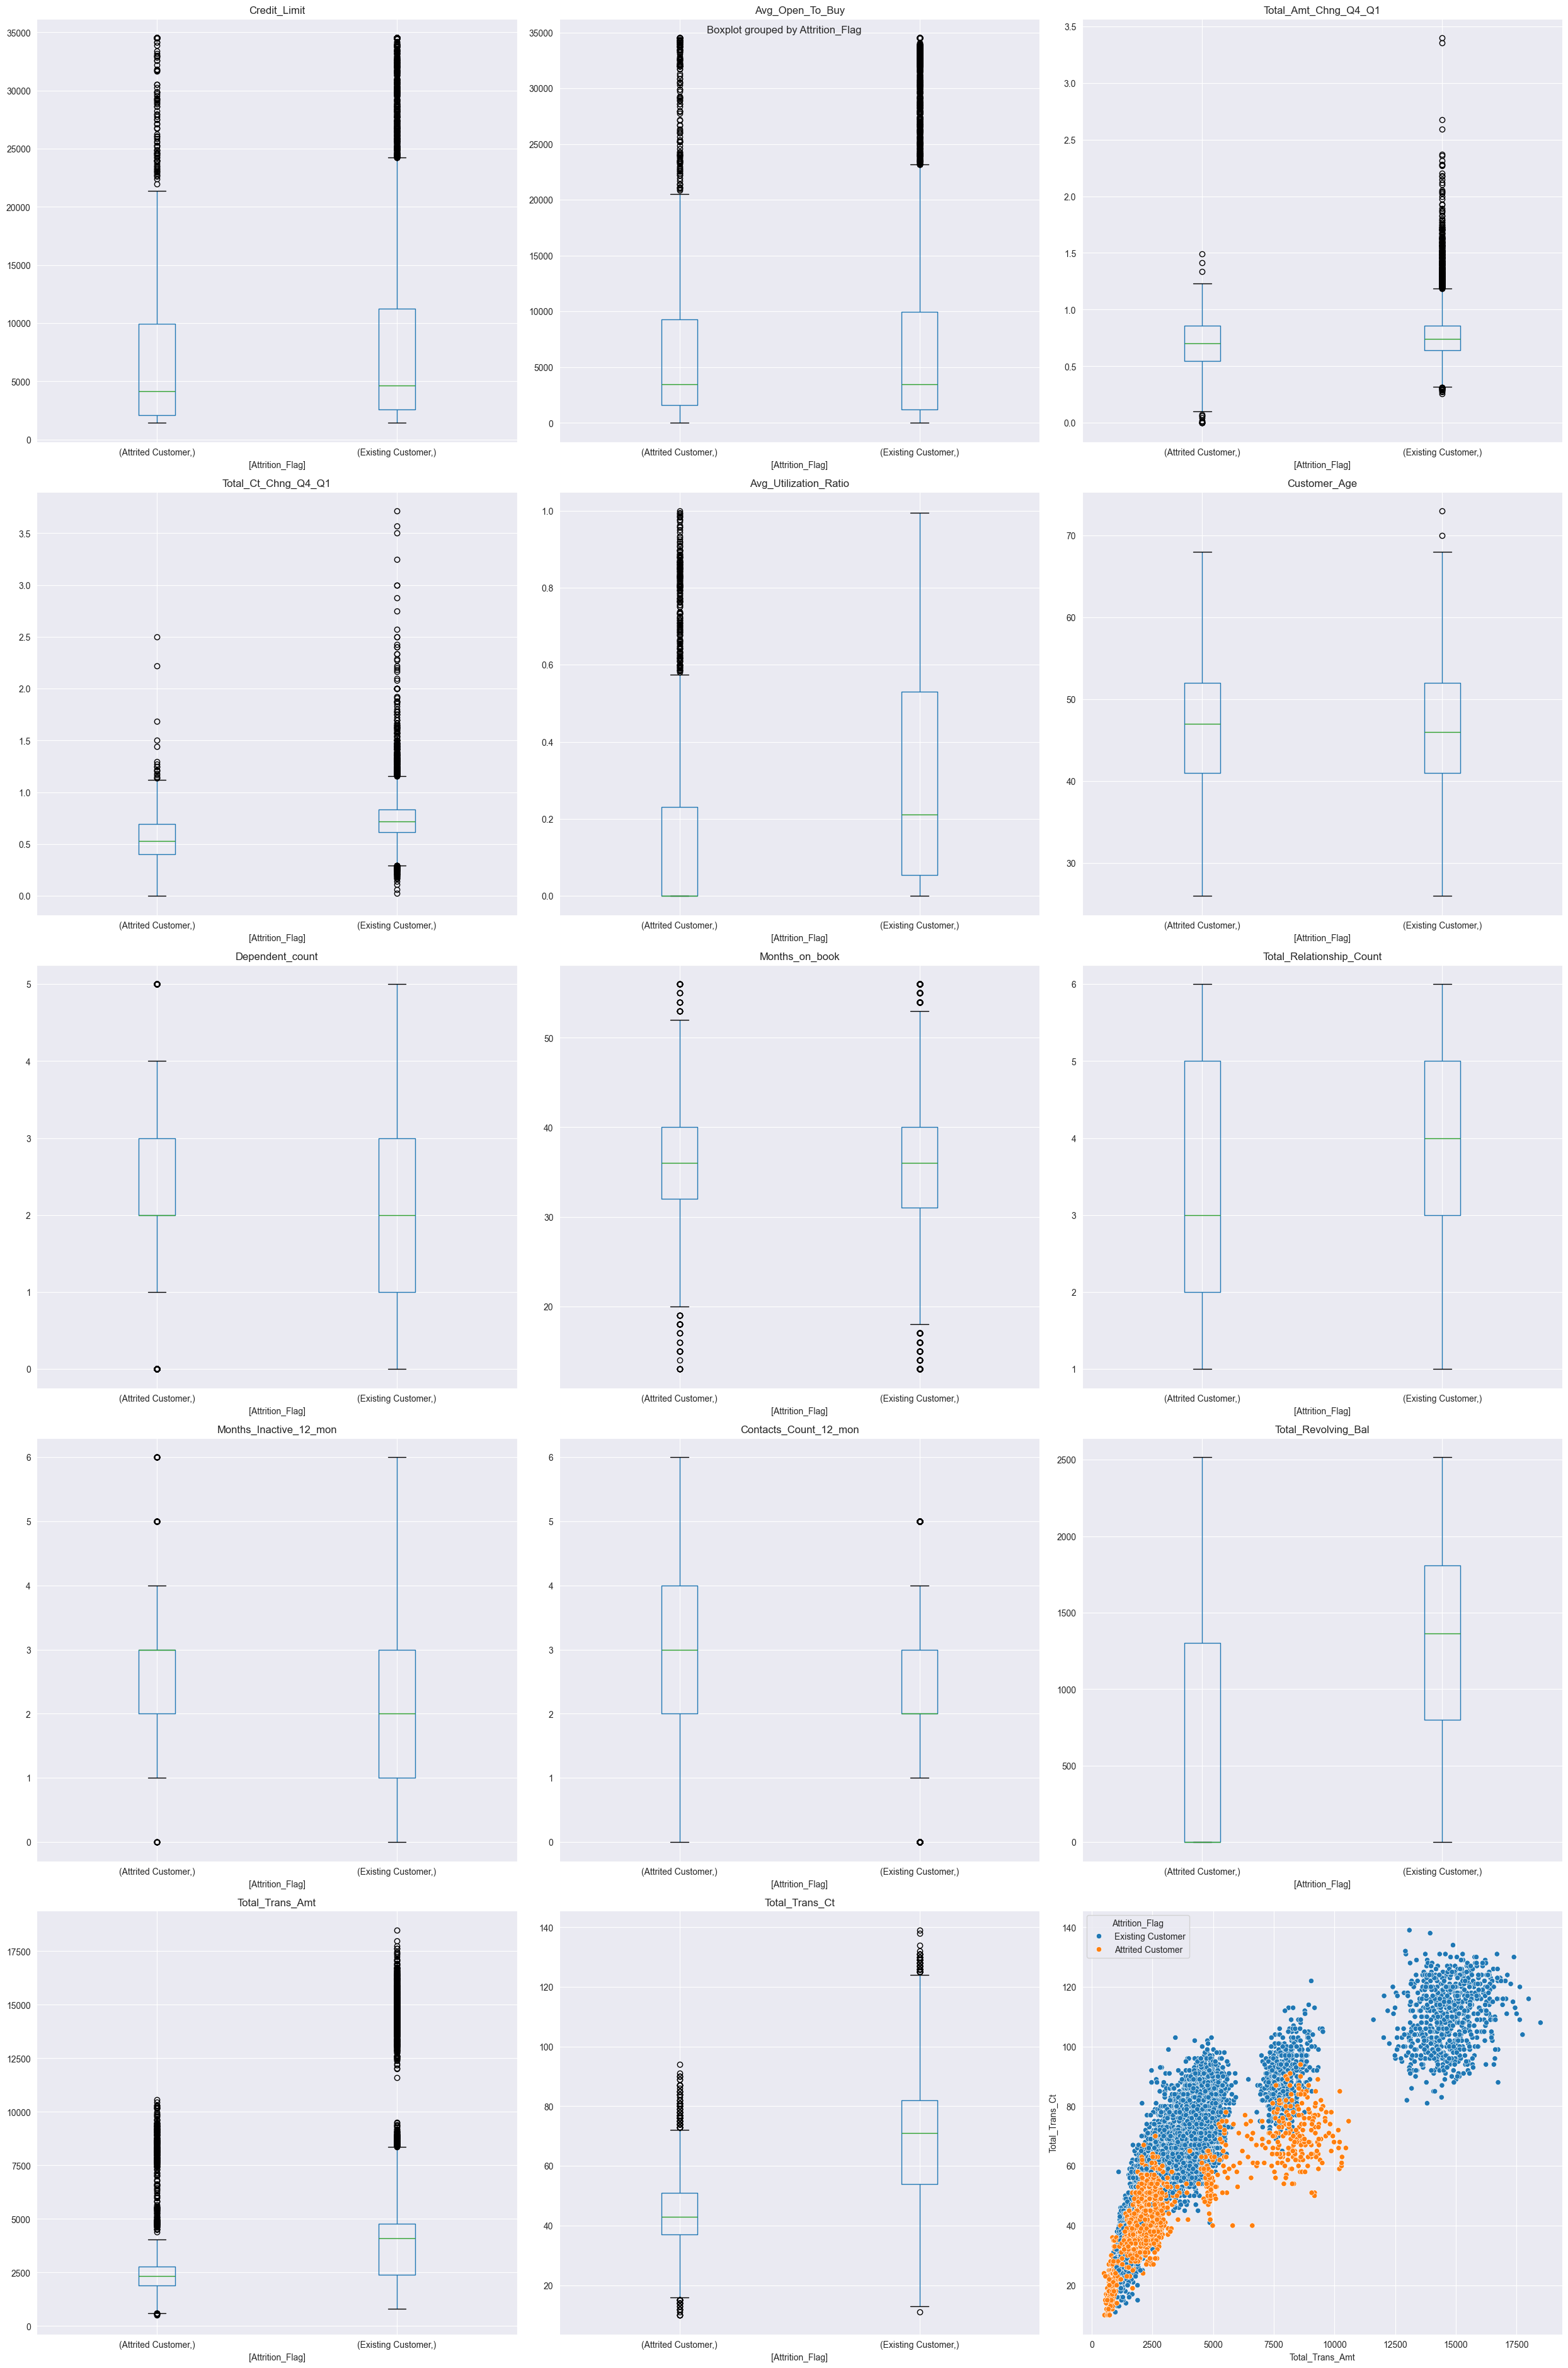

Index(['Credit_Limit', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1',
       'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')
Index(['CLIENTNUM', 'Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Total_Trans_Amt',
       'Total_Trans_Ct'],
      dtype='object')


In [7]:
fig, axes = plt.subplots(5, 3, figsize=(25, 38))

df.boxplot(column=['Credit_Limit'], by=['Attrition_Flag'], ax=axes[0,0])

df.boxplot(column=['Avg_Open_To_Buy'], by=['Attrition_Flag'], ax=axes[0,1])

df.boxplot(column=['Total_Amt_Chng_Q4_Q1'], by=['Attrition_Flag'], ax=axes[0,2])

df.boxplot(column=['Total_Ct_Chng_Q4_Q1'], by=['Attrition_Flag'], ax=axes[1,0])

df.boxplot(column=['Avg_Utilization_Ratio'], by=['Attrition_Flag'], ax=axes[1,1])

df.boxplot(column=['Customer_Age'], by=['Attrition_Flag'], ax=axes[1,2])

df.boxplot(column=['Dependent_count'], by=['Attrition_Flag'], ax=axes[2,0])

df.boxplot(column=['Months_on_book'], by=['Attrition_Flag'], ax=axes[2,1])

df.boxplot(column=['Total_Relationship_Count'], by=['Attrition_Flag'], ax=axes[2,2])

df.boxplot(column=['Months_Inactive_12_mon'], by=['Attrition_Flag'], ax=axes[3,0])

df.boxplot(column=['Contacts_Count_12_mon'], by=['Attrition_Flag'], ax=axes[3,1])

df.boxplot(column=['Total_Revolving_Bal'], by=['Attrition_Flag'], ax=axes[3,2])

df.boxplot(column=['Total_Trans_Amt'], by=['Attrition_Flag'], ax=axes[4,0])

df.boxplot(column=['Total_Trans_Ct'], by=['Attrition_Flag'], ax=axes[4,1])

sns.scatterplot(data=df, x='Total_Trans_Amt', y='Total_Trans_Ct', hue='Attrition_Flag', ax=axes[4,2]) # mais um plot só pra completar o grid


plt.tight_layout()
plt.show()

print(df.select_dtypes(include='float64').columns)
print(df.select_dtypes(include='int64').columns)

# Olhando para essas variáveis, algumas carateristicas parecem diferenciar os grupos de clientes desistentes e existentes.

# Em especial, nos ultimos plots, fica claro um ponto acima do qual tanto para Total_Trans_Amt ( > ~11000) quanto para Total_Trans_Ct ( > ~100) não existem clientes desistentes. Isso pode indicar uma relevância maior desse parâmetro na classificação do risco de um cliente existente cancelar sua conta.

In [8]:
df.isna().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

#Começamos a partir daqui a tratar os dados para um formato que possa ser usado no modelo que criaremos mais adiante.

In [9]:
df.replace('Unknown', np.nan, inplace=True)
df.dropna(inplace=True) # Eliminamos os elementos desconhecidos

df.drop(['CLIENTNUM'], axis=1, inplace=True)  #Eliminamos a coluna de numero de
                                              #cliente já que ela não pode influenciar na nossa análise

print(df.shape)


(7081, 20)


In [10]:
#Criamos um novo dataframe, transformando as variáveis categóricas em numéricas

df2 = pd.concat([df['Attrition_Flag'].replace({'Existing Customer': 0, 'Attrited Customer': 1}),
                df['Gender'].replace({'M': 0, 'F': 1}),
                pd.get_dummies(df['Education_Level']),
                pd.get_dummies(df['Marital_Status']),
                pd.get_dummies(df['Income_Category']),
                pd.get_dummies(df['Card_Category']),
                df.select_dtypes(include='float64'),
                df.select_dtypes(include='int64')],
                axis=1)


C:\Users\84284528572\AppData\Local\Temp\ipykernel_508\287166687.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2 = pd.concat([df['Attrition_Flag'].replace({'Existing Customer': 0, 'Attrited Customer': 1}),
C:\Users\84284528572\AppData\Local\Temp\ipykernel_508\287166687.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'].replace({'M': 0, 'F': 1}),


# O DataFrame df2 agora contem apenas variaveis que podem ser utilizadas na função que cria um modelo de random forest.

# Random forest é um modelo muito utilizado pela sua robustes e bons resultados que costuma gerar em uma abrangente gama de problemas. Podemos passar para a função variáveis numéricas continuas ou discretas (temos nesses caso float64 e int64) e também variáveis booleanas (True e False)

In [11]:
# x contem as variáveis que servirão para a previsão de Attrition_Flag
x= df2.drop('Attrition_Flag', axis=1)

# y é a variável que queremos avaliar a partir de x. Ou seja, usar os valores
# de x para prever se o cliente cancela ou não sua conta
y= df2['Attrition_Flag']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)



In [12]:
# Podemos conferir se no grupo de treino e no grupo de teste a proporção
# de clientes existentes e cancelados é razoavel (garantir que existe representação
# dos dois casos nos dois grupos). Nesse caso, a proporção nos dois grupos
# é bem semelhante.

print(y_train.value_counts())
print(y_test.value_counts())

Attrition_Flag
0    4763
1     901
Name: count, dtype: int64
Attrition_Flag
0    1205
1     212
Name: count, dtype: int64


<Axes: >

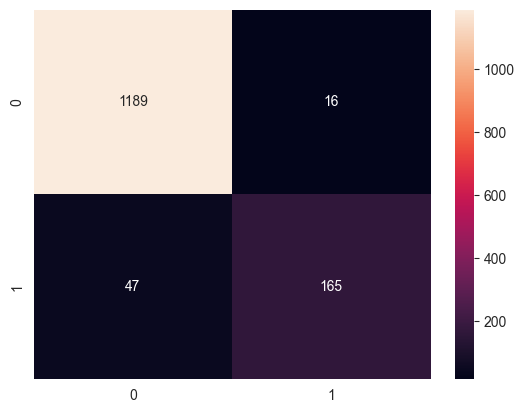

In [13]:
# Criamos agora o modelo1, usando RandomForestClassifier
# Essa função criará um conjunto de árvores de decisão que aleatoriamente escolhe um conjunto de parâmetros
# que servirão de guia para a decisão de se um cliente cancela ou não sua conta.
modelo1= RandomForestClassifier(random_state=0)

modelo1.fit(x_train, y_train)     # Treina o modelo usando os dados separados para treinamento (em bloco anterior com a função train_test_split).
# A função fit nesse caso está ajustando os parâmetros internos de cada árvore de
# decisão de forma que ela tenho melhor precisão na previsão dentro do modelo de treinamento.
# Após essa função, a estrutura (floresta) otimizada pode ser usada com um dado
# teste (x_test) para avaliar quão bem esse modelo gerado ficou.

y_previsto = modelo1.predict(x_test) # Usa o modelo otimizado para avaliar
# o conujnto de teste. Desse conjunto ele gera o y_previsto. Esse será
# comparado ao y_test. Quanto mais próximo y_previsto for de y_test,
# mais bem ajustado o modelo ficou.

cf_mat = confusion_matrix(y_test, y_previsto) # Geramos uma visualização
# entre y_test e y_previsto para avaliar as previsões certeiras e as previsões
# equivocadas.

sns.heatmap(cf_mat, annot=True, fmt='g')



In [14]:

modelo1.fit(x_train,y_train)
all_pred_probs = modelo1.predict_proba(x_test)[:, 1]

x_test['Churn_Probability'] = all_pred_probs
x_test['Attrition_Flag'] = y_test

<Axes: xlabel='Total_Trans_Amt', ylabel='Churn_Probability'>

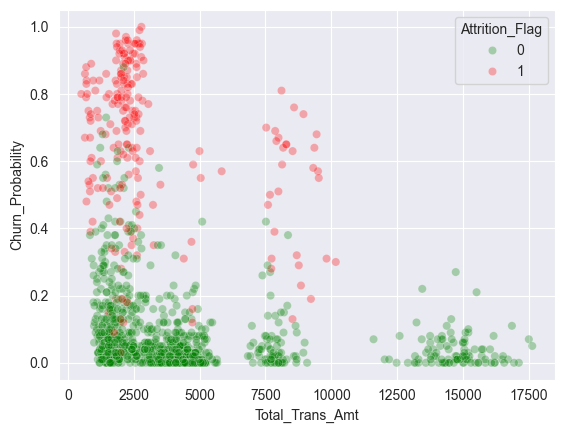

In [15]:
sns.scatterplot(x='Total_Trans_Amt', y='Churn_Probability', alpha=0.3, hue='Attrition_Flag', data=x_test, palette=['green', 'red'])

# Vamos testar um segundo modelo em que usamos menos parâmetros

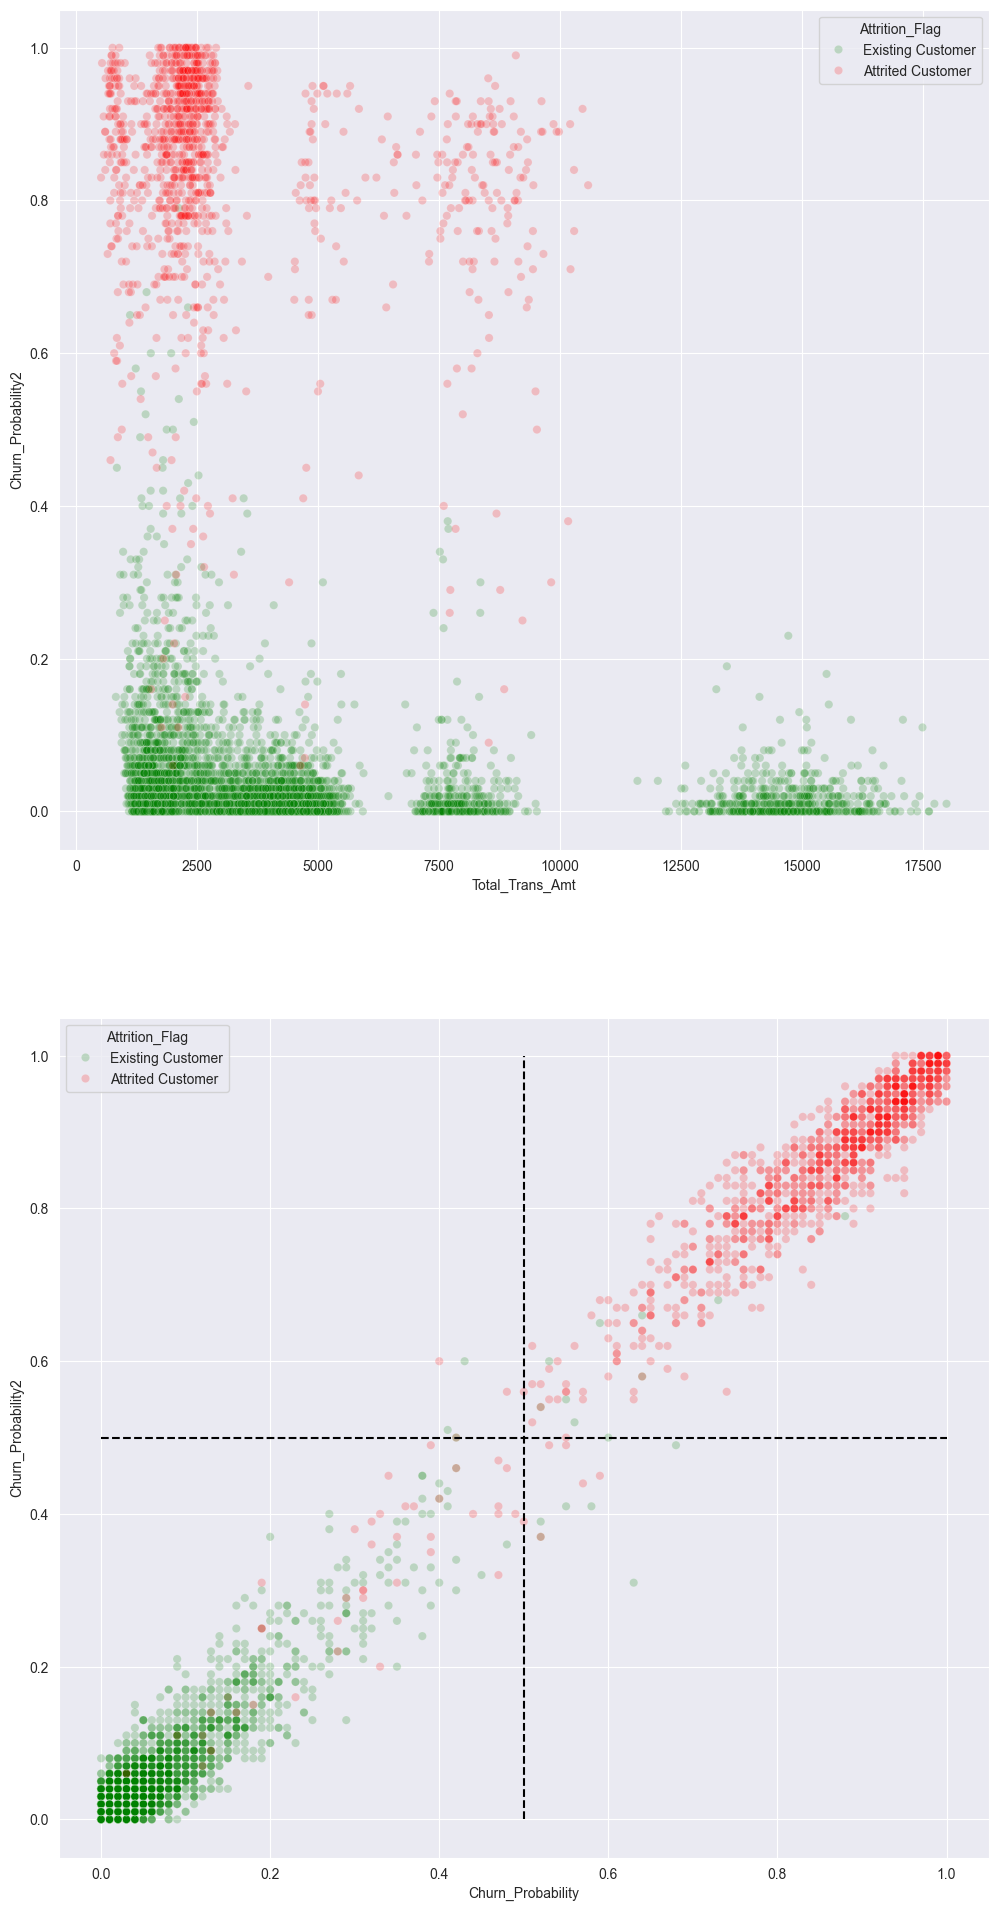

In [16]:
# x2 não usará Credit_Limit
x2 = df2.drop(['Attrition_Flag','Credit_Limit'], axis=1)

y2 = df2['Attrition_Flag']

x2_train, x2_test, y2_train, y2_test = train_test_split(
    x2, y2, test_size=0.2, random_state=42)

modelo2= RandomForestClassifier(random_state=0)

modelo2.fit(x2_train, y2_train)

y2_previsto = modelo2.predict(x2_test)


fig, axes = plt.subplots(2, 1, figsize=(12, 24))


modelo2.fit(x2_train,y2_train)
all_pred_probs2 = modelo2.predict_proba(x2)[:, 1]
fpr, tpr, thresholds = roc_curve(y2, all_pred_probs2)
df['Churn_Probability2'] = all_pred_probs2
df['Churn_Probability']= modelo1.predict_proba(x)[:, 1]


sns.scatterplot(x='Total_Trans_Amt', y='Churn_Probability2', alpha=0.2, hue='Attrition_Flag', data=df, palette=['green', 'red'], ax=axes[0])


# Para observar melhor a diferença entre os dois modelos, podemos plotar a probabilidade de um modelo em função da probabilidade do outro.
sns.scatterplot(x='Churn_Probability', y='Churn_Probability2', alpha=0.2, hue='Attrition_Flag', data=df, palette=['green', 'red'], ax=axes[1])
axes[1].vlines(0.5, ymin=0, ymax=1, color='black', linestyles='--')
axes[1].hlines(0.5, xmin=0, xmax=1, color='black', linestyles='--')

# Nesse plot podemos enxergar a diferença na classificação pelo modelo1 e pelo modelo2. Se as previsões fossem iguais, todos os pontos apareceriam na diagonal
# O valor no eixo x corresponde a probabilidade de cancelamento pelo modelo 1 e no eixo y a probabilidade calculada pelo modelo 2.

# O threshold de classificação do algoritmo é 0.5. Ou seja, ele classifica desistentes como aqueles que tem probabilidade maior que 0.5
# Pontos que aparecem na região NO(SE) indicam pontos que tiverem classificação desistente no modelo 2(1) e existente no modelo 1(2).
# Pontos que aparecem na região SO ou NE são pontos que receberam a mesma classificação em ambos modelos.
# Como poucos pontos aparecem nas regiões NO e SE, isso indica que não utilizar 'Credit_Limit' no modelo afetou pouco o poder de previsão.

# Você pode testar eliminar outras variáveis e observar o seu impacto no modelo.


plt.show()

# Exercícios

Qual é a média de utilização (Avg_Utilization_Ratio) por categoria de cartão?

In [17]:
media_dados = df.groupby('Card_Category')["Avg_Utilization_Ratio"].mean()

display(media_dados)
print(media_dados)

Card_Category
Blue        0.298690
Gold        0.057914
Platinum    0.047727
Silver      0.059038
Name: Avg_Utilization_Ratio, dtype: float64

Card_Category
Blue        0.298690
Gold        0.057914
Platinum    0.047727
Silver      0.059038
Name: Avg_Utilization_Ratio, dtype: float64



Quais combinações de nível de renda e escolaridade têm os maiores valores médios de transação?

In [19]:
dados_media2 = df.groupby(['Income_Category', 'Education_Level'])['Total_Trans_Amt'].mean()
print(dados_media2)

Income_Category  Education_Level
$120K +          College            4032.292308
                 Doctorate          4336.371429
                 Graduate           4515.742424
                 High School        4060.899281
                 Post-Graduate      4799.740741
                 Uneducated         5165.731481
$40K - $60K      College            4484.252874
                 Doctorate          4121.044776
                 Graduate           4384.750491
                 High School        4148.371601
                 Post-Graduate      4836.733333
                 Uneducated         4353.681416
$60K - $80K      College            4527.877049
                 Doctorate          3458.113208
                 Graduate           4508.744186
                 High School        4577.866667
                 Post-Graduate      4638.216216
                 Uneducated         4456.516484
$80K - $120K     College            4175.395062
                 Doctorate          4424.636364
       


Monte uma visualização (gráfico de barras) comparando o número médio de transações para clientes ativos vs inativos por faixa de renda.

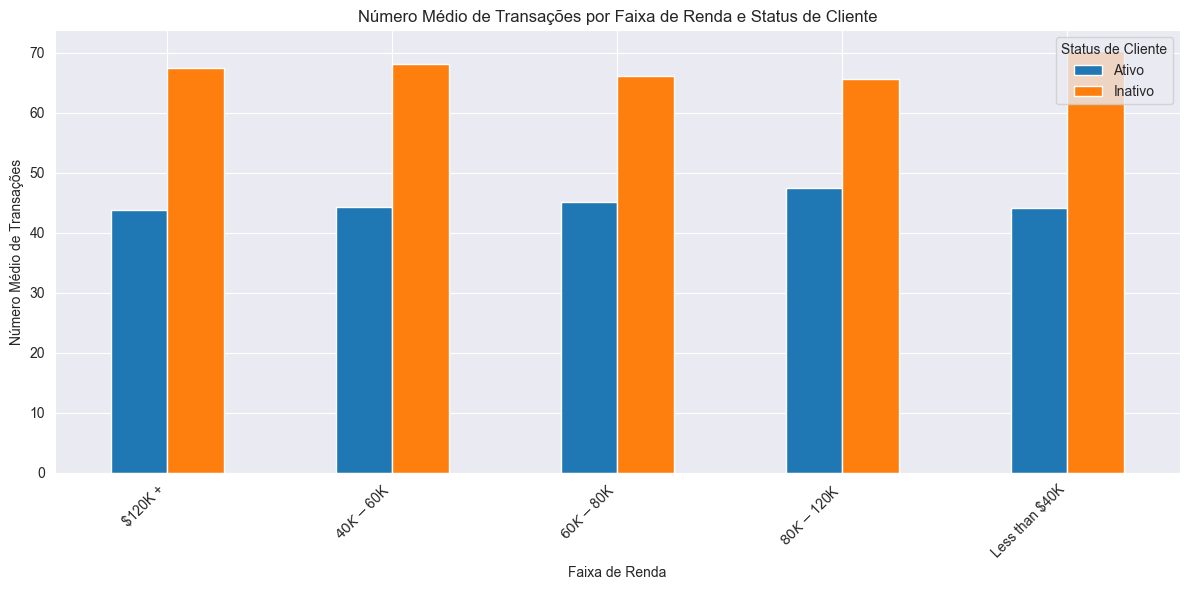

In [20]:

media_transacoes_por_renda = df.groupby(['Income_Category', 'Attrition_Flag'])['Total_Trans_Ct'].mean().unstack()


media_transacoes_por_renda.plot(kind='bar', figsize=(12, 6))
plt.title('Número Médio de Transações por Faixa de Renda e Status de Cliente')
plt.xlabel('Faixa de Renda')
plt.ylabel('Número Médio de Transações')
plt.legend(title='Status de Cliente', labels=['Ativo', 'Inativo'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Crie um novo cubo com as dimensões Gender, Card_Category, e Attrition_Flag e agregue Total_Trans_Amt.

In [21]:
cubo = df.groupby(['Gender', 'Card_Category', 'Attrition_Flag'])['Total_Trans_Amt'].sum()
cubo

Gender  Card_Category  Attrition_Flag   
F       Blue           Attrited Customer     1473277
                       Existing Customer    11949848
        Gold           Attrited Customer       39210
                       Existing Customer      126711
        Platinum       Attrited Customer        9702
                       Existing Customer       15513
        Silver         Attrited Customer       68989
                       Existing Customer      722521
M       Blue           Attrited Customer     1575854
                       Existing Customer    12825704
        Gold           Attrited Customer       50043
                       Existing Customer      458390
        Platinum       Attrited Customer        4758
                       Existing Customer       81311
        Silver         Attrited Customer      235475
                       Existing Customer     1478731
Name: Total_Trans_Amt, dtype: int64

Qual grupo de clientes apresenta nesse cubo o maior risco de churn com base em Attrition_Flag?

In [22]:
maior_risco_churn = cubo.loc[:, :, 'Attrited Customer'].idxmax()

print(f"O grupo com maior risco de churn é: {maior_risco_churn}")

O grupo com maior risco de churn é: ('M', 'Blue')
